In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt 

%matplotlib inline

#These two lines will tell jupyter notebook to print all vars instead of last listed var
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
class XML2DataFrame:

    def __init__(self, xml_data):
        self.root = ET.XML(xml_data)

    def parse_root(self, root):
        return [self.parse_element(child) for child in iter(root)]

    def parse_element(self, element, parsed=None):
        if parsed is None:
            parsed = dict()
        for key in element.keys():
            parsed[key] = element.attrib.get(key)
        if element.text:
            parsed[element.tag] = element.text
        for child in list(element):
            self.parse_element(child, parsed)
        return parsed

    def process_data(self):
        structure_data = self.parse_root(self.root)
        return pd.DataFrame(structure_data)

In [ ]:
# Get list of XML file names from the data directory
import os 

files = []
directory = os.fsencode("data")
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".xml"): 
        #print(filename)
        files.append("data\\" + filename)
        continue
    else:
        continue
                     
files

In [ ]:
# Create an empty dataframe for us to add all our data into
master_df = pd.DataFrame()
master_df

In [ ]:
# Create an empty list for us to track column names for each year's worth of data
column_names = []

In [ ]:
ts = time.time()
st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
print('start time = ', st)

# For every xml file in the directory, convert xml file to dataframe
# Add the dataframe to the master dataframe
for f in files:
    xml_data = open(f).read()
    xml2df = XML2DataFrame(xml_data)
    xml_dataframe = xml2df.process_data()
    column_names.append(xml_dataframe.columns)
    master_df = pd.concat([master_df,xml_dataframe], ignore_index=True)
    open(f).close()
    
ts = time.time()
st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
print('end time = ', st)

In [ ]:
# Check the master dataframe
master_df.info()

In [ ]:
# Write the master dataframe to CSV
master_df.to_csv('TFS_OPEN_DATA-2011-2016.csv', encoding='utf-8', index=False)

In [ ]:
# Column names for each of the data files 
column_names

In [ ]:
# Find the differences in column names between the data
# Print the columns which were found in one data set but not another
for i in range(1, len(column_names)):
    print ("i = " + str(i))
    print (set(column_names[i]) - set(column_names[i-1]))
    print (set(column_names[i-1]) - set(column_names[i]))

In [ ]:
# Let's shorten the dataframe name so we can write code easier and peek at the data
df = master_df
df.head(10)

In [2]:
df = pd.read_csv('TFS_OPEN_DATA-2011-2016.csv')
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (43,50,85) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,AGENT_APP_HOUR,AGENT_APP_MIN,AGENT_APP_SEC,AGE_OF_STRUCTURE,AID_TO_FROM_OTHER_DEPTS,ALARM_TO_FD,AREA_OF_ORIGIN,ARRIVE_DATE,ARRIVE_TIME,BLD_HEIGHT,...,SMOKE_ALARM_PRESENCE_AND_OPERATION_MAIN_FLOOR,SMOKE_ALARM_TYPE,SPRINKLER_SYSTEM_ACTIVATION,SPRINKLER_SYSTEM_PRESENCE,STATUS_ON_ARRIVAL,TOTAL_NUM_PERSONNEL,TSSA,VEH_FUEL,VEH_PURPOSE,WATER
0,NaN,NaN,NaN,NaN,4,3.0,NaN,2011-01-01 00:10:02,2011-01-01 00:10:02,0,...,NaN,NaN,NaN,NaN,NaN,4,,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,4,1.0,NaN,2011-01-01 00:09:02,2011-01-01 00:09:02,0,...,NaN,NaN,NaN,NaN,NaN,4,,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,4,3.0,NaN,2011-01-01 00:09:34,2011-01-01 00:09:34,0,...,NaN,NaN,NaN,NaN,NaN,4,,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,4,1.0,NaN,2011-01-01 00:10:46,2011-01-01 00:10:46,0,...,NaN,NaN,NaN,NaN,NaN,4,,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,1,5.0,NaN,2011-01-01 00:11:03,2011-01-01 00:12:38,0,...,NaN,NaN,NaN,NaN,NaN,14,,NaN,NaN,NaN


In [ ]:
# Drop the columns from our <Responding Units> sub data since we weren't able to import them correctly
# There are multiple Responding Units made of these 5 attributes EACH but we were only able to read in
# one of possibly many Responding Units data so, we'll discard for now as it is incomplete data
df = df.drop(['CAD_UNIT_ID','DISPATCH_TIME','ENROUTE_TIME','ARRIVE_TIME','CLEAR_TIME'], axis=1)

In [ ]:
# Note that there are 107 columns, but not all of them can be shown on screen
# So let's peek at the first few rows, 10 columns at a time to look at a sample of the data
for i in range(0, len(df.columns), 10):
    df.iloc[:,i:i+10].head()

In [ ]:
# Describe the data 10 columns at a time
for i in range(0, len(df.columns), 10):
    df.iloc[:,i:i+10].describe(include='all')

## Data Wrangling

In [3]:
# From the column comparison that we did as we were processing each year's worth of data
# we see that EVENT_ALARM_LEVEL and FIRE_DEPT_INCIDENT data were missing from some data sets
# So we'll drop those incomplete attributes 
df = df.drop(['EVENT_ALARM_LEVEL','FIRE_DEPT_INCIDENT'], axis=1)

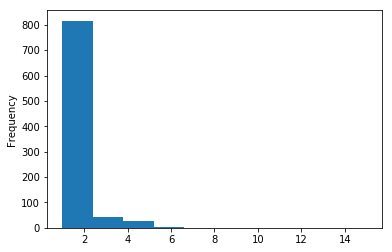

In [4]:
# We will combine all injuries and fatalities into a total number of injuries attribute
df['Injuries'] = (df.filter(regex='INJUR|FATAL').astype(int)).sum(axis=1)

# Let's see what the spread of injuries look like
df[df['Injuries']>0].Injuries.sort_values().plot(kind='hist')

In [5]:
# Since there isn't great variety in the number of injuries, let's refine
# this attribute to 0 for no injury, 1 for (any number of) injuries exist
df['Injuries'] = (df['Injuries'] > 0).astype(int)
df['Injuries'].groupby(df['Injuries']).count()

Injuries
0    719479
1       891
Name: Injuries, dtype: int64

In [ ]:
# Remove the attribues we no longer need
df = df.drop(df.filter(regex='INJUR|FATAL').columns, axis=1)

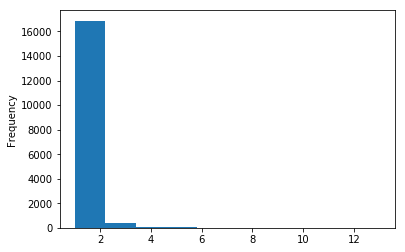

In [6]:
# Combine number of the other agencies and/or parties contacted to a single attribute
other_contacts = ['OPP','MOE','TSSA','ESA','MOL','EMS','CANUTEC','GAS','HYDRO','MUNICIPAL_BUILDING_OFFICE','MUNICIPAL_HEALTH_OFFICE','MUNICIPAL_POLICE','OFM_INVESTIGATIONS_CONTACTED','OTHER']

# We'll start by converting the blank spaces to numeric values
for contact in other_contacts:
    df[contact] = pd.to_numeric(df[contact], errors='coerce').fillna(0)
df['OTHERS_CONTACTED'] = df[other_contacts].astype(int).sum(axis=1)

# Let's see what the data spread looks like
df[df['OTHERS_CONTACTED']>0].OTHERS_CONTACTED.sort_values().plot(kind='hist')

In [7]:
# Since there isn't great variety in the number other agencies contacted, let's refine
# this attribute to 0 for no other agency contacted, 1 for (any number of) other agency contacted
df['OTHERS_CONTACTED'] = (df['OTHERS_CONTACTED'] > 0).astype(int)
df['OTHERS_CONTACTED'].groupby(df['OTHERS_CONTACTED']).count()

OTHERS_CONTACTED
0    702941
1     17429
Name: OTHERS_CONTACTED, dtype: int64

In [8]:
# Remove the attribues we no longer need
df = df.drop(df[other_contacts], axis=1)

In [9]:
# Let's look at the data that has date and time info
df.filter(regex='DATE|HOUR|MIN|SEC|TIME').head()

,AGENT_APP_HOUR,AGENT_APP_MIN,AGENT_APP_SEC,ARRIVE_DATE,ARRIVE_TIME,CLEAR_TIME,CONTROL_DATE,CONTROL_HOUR,CONTROL_MIN,CONTROL_SEC,...,DISPATCH_SEC,DISPATCH_TIME,ENROUTE_TIME,INCIDENT_DATE,INITIAL_CALL_HOUR,INITIAL_CALL_MIN,INITIAL_CALL_SEC,ONSCENE_HOUR,ONSCENE_MIN,ONSCENE_SEC
0,NaN,NaN,NaN,2011-01-01 00:10:02,2011-01-01 00:10:02,2011-01-01 00:31:19,NaN,NaN,NaN,NaN,...,13.0,2011-01-01 00:04:13,2011-01-01 00:05:45,01/01/2011,0,3,43,0.0,10.0,2.0
1,NaN,NaN,NaN,2011-01-01 00:09:02,2011-01-01 00:09:02,2011-01-01 00:15:14,NaN,NaN,NaN,NaN,...,46.0,2011-01-01 00:04:46,2011-01-01 00:07:30,01/01/2011,0,3,55,0.0,9.0,2.0
2,NaN,NaN,NaN,2011-01-01 00:09:34,2011-01-01 00:09:34,2011-01-01 00:27:12,NaN,NaN,NaN,NaN,...,50.0,2011-01-01 00:05:50,NaN,01/01/2011,0,5,3,0.0,9.0,34.0
3,NaN,NaN,NaN,2011-01-01 00:10:46,2011-01-01 00:10:46,2011-01-01 00:20:40,NaN,NaN,NaN,NaN,...,33.0,2011-01-01 00:06:33,2011-01-01 00:08:48,01/01/2011,0,4,46,0.0,10.0,46.0
4,NaN,NaN,NaN,2011-01-01 00:11:03,2011-01-01 00:12:38,2011-01-01 00:15:31,NaN,NaN,NaN,NaN,...,41.0,2011-01-01 00:06:41,2011-01-01 00:09:07,01/01/2011,0,6,7,0.0,11.0,3.0


In [10]:
# We can see that 'dispatch' information has lots of repeated data
# Let's see if we can optimize by filling in missing data and removing duplicate data
# Let's see again what that data looks like
df.filter(regex='DISPATCH|INCIDENT_DATE').describe(include='all')
df.filter(regex='DISPATCH|INCIDENT_DATE').head()

,DISPATCH_DATE,DISPATCH_HOUR,DISPATCH_MIN,DISPATCH_SEC,DISPATCH_TIME,INCIDENT_DATE
count,719679,720193.000000,720193.000000,720193.000000,719347,720370
unique,718149,NaN,NaN,NaN,717829,2192
top,2013-08-03 16:25:57,NaN,NaN,NaN,2014-03-28 13:04:15,22/12/2013
freq,4,NaN,NaN,NaN,4,2752
mean,NaN,12.953839,29.499231,29.501899,NaN,NaN
std,NaN,6.364254,17.308797,17.315648,NaN,NaN
min,NaN,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,9.000000,15.000000,15.000000,NaN,NaN
50%,NaN,13.000000,30.000000,29.000000,NaN,NaN
75%,NaN,18.000000,44.000000,45.000000,NaN,NaN


,DISPATCH_DATE,DISPATCH_HOUR,DISPATCH_MIN,DISPATCH_SEC,DISPATCH_TIME,INCIDENT_DATE
0,2011-01-01 00:04:13,0.0,4.0,13.0,2011-01-01 00:04:13,01/01/2011
1,2011-01-01 00:04:46,0.0,4.0,46.0,2011-01-01 00:04:46,01/01/2011
2,2011-01-01 00:05:50,0.0,5.0,50.0,2011-01-01 00:05:50,01/01/2011
3,2011-01-01 00:06:33,0.0,6.0,33.0,2011-01-01 00:06:33,01/01/2011
4,2011-01-01 00:06:41,0.0,6.0,41.0,2011-01-01 00:06:41,01/01/2011


In [11]:
# We'll try and fill in DISPATCH_DATE it is most complete (within the row) with date and time info 
# First we'll convert the INCIDENT_DATE and DISPATCH_DATE to datetime type so we can work with it easier
df['INCIDENT_DATE'] = pd.to_datetime(df['INCIDENT_DATE'], format='%d/%m/%Y')
df['DISPATCH_DATE'] = pd.to_datetime(df['DISPATCH_DATE'], format='%Y-%m-%d %H:%M:%S')

# Next, we'll get indices for rows where DISPATCH_DATE is missing data but data exists for the time attributes
dispatchix = df[df.DISPATCH_DATE.isnull() & df.DISPATCH_HOUR.notnull() & df.DISPATCH_MIN.notnull() & df.DISPATCH_SEC.notnull()].index

# We'll fill in missing time values with 0 so we can convert the attribute to an int
df['DISPATCH_HOUR'] = df['DISPATCH_HOUR'].fillna(0)
df['DISPATCH_MIN'] = df['DISPATCH_MIN'].fillna(0)
df['DISPATCH_SEC'] = df['DISPATCH_SEC'].fillna(0)
df['DISPATCH_HOUR'] = df['DISPATCH_HOUR'].astype(int)
df['DISPATCH_MIN'] = df['DISPATCH_MIN'].astype(int)
df['DISPATCH_SEC'] = df['DISPATCH_SEC'].astype(int)

# Create a temp attribute to contain our combined dispatch date and time information 
df['DISPATCH_TEMP'] = df['INCIDENT_DATE'] + pd.to_timedelta(df.DISPATCH_SEC, unit='s') + pd.to_timedelta(df.DISPATCH_MIN, unit='m') + pd.to_timedelta(df.DISPATCH_HOUR, unit='h')

# Replace our missing data with the data that we've constructed
for ix in dispatchix:
    df.loc[ix,'DISPATCH_DATE'] = df.loc[ix,'DISPATCH_TEMP']

# Confirm that we have fewer missing values now
df.DISPATCH_DATE.describe()

count                  720367
unique                 718832
top       2013-08-03 16:25:57
freq                        4
first     2011-01-01 00:02:50
last      2016-12-31 23:59:58
Name: DISPATCH_DATE, dtype: object

In [12]:
# Since we can't fill in anymore values, we'll drop the attributes that we no longer need
df = df.drop(['DISPATCH_HOUR','DISPATCH_MIN','DISPATCH_SEC','DISPATCH_TEMP'], axis=1)

In [13]:
# We'll do similarly as above for ARRIVE_DATE and ONSCENE_HOUR/MIN/SEC
df['ARRIVE_DATE'] = pd.to_datetime(df['ARRIVE_DATE'], format='%Y-%m-%d %H:%M:%S')
arriveix = df[df.ARRIVE_DATE.isnull() & df.ONSCENE_HOUR.notnull() & df.ONSCENE_MIN.notnull() & df.ONSCENE_SEC.notnull()].index
df['ONSCENE_HOUR'] = df['ONSCENE_HOUR'].fillna(0)
df['ONSCENE_MIN'] = df['ONSCENE_MIN'].fillna(0)
df['ONSCENE_SEC'] = df['ONSCENE_SEC'].fillna(0)
df['ONSCENE_HOUR'] = df['ONSCENE_HOUR'].astype(int)
df['ONSCENE_MIN'] = df['ONSCENE_MIN'].astype(int)
df['ONSCENE_SEC'] = df['ONSCENE_SEC'].astype(int)
df['ARRIVE_TEMP'] = df['INCIDENT_DATE'] + pd.to_timedelta(df.ONSCENE_SEC, unit='s') + pd.to_timedelta(df.ONSCENE_MIN, unit='m') + pd.to_timedelta(df.ONSCENE_HOUR, unit='h')
for ix in dispatchix:
    df.loc[ix,'ARRIVE_DATE'] = df.loc[ix,'ARRIVE_TEMP']

In [14]:
df = df.drop(df.filter(regex='ONSCENE_|ARRIVE_TEMP').columns, axis=1)

In [ ]:
# TO DO: Combine other time fields into one datetime field OR drop them
df.filter(regex='DATE|HOUR|MIN|SEC').head()

In [15]:
# There are also a number of columns with "RESCUE" in the name
df.filter(regex='RESCUE').head()

,RESCUED_ADULTS,RESCUED_CHILDREN,RESCUED_SENIORS,RESCUES
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


In [16]:
# We'll combine the RESCUED_* attributes to form a sum
df['RESCUE_SUM'] = (df['RESCUED_ADULTS'] + df['RESCUED_CHILDREN'] + df['RESCUED_SENIORS'])

# And compare the sum with the RESCUES column to see if they're the same data
df[df.RESCUES>0].shape
df[(df.RESCUE_SUM == df.RESCUES) & df.RESCUES>0].shape

(7907, 88)

(209, 88)

In [17]:
df[(df.RESCUE_SUM != df.RESCUES) & df.RESCUES>0].shape
df[(df.RESCUE_SUM != df.RESCUES) & df.RESCUES>0][['RESCUE_SUM','RESCUES']].head()

(5146, 88)

,RESCUE_SUM,RESCUES
149,0,1
284,0,3
618,0,1
668,0,3
828,0,1


In [18]:
df[(df.RESCUE_SUM != df.RESCUES) & df.RESCUE_SUM>0].shape
df[(df.RESCUE_SUM != df.RESCUES) & df.RESCUE_SUM>0][['RESCUE_SUM','RESCUES']].head()

(71, 88)

,RESCUE_SUM,RESCUES
6448,5,0
9149,3,0
9276,1,0
11501,1,0
12213,1,0


In [19]:
# Looks like we have very few crossovers
# In other words, RESUCES != RESCUED_ADULTS + RESCUED_CHILDREN + RESCUED_SENIORS
# So let's combine all 4 attributes to 1 attribute: 0 for no rescues; 1 otherwise 
df['RESCUED'] = ((df['RESCUE_SUM'] > 0) | (df['RESCUES'] > 0)).astype(int)
df['RESCUED'].groupby(df['RESCUED']).count()

RESCUED
0    712322
1      8048
Name: RESCUED, dtype: int64

In [ ]:
# We'll drop the columns that we no longer need
df = df.drop(df.filter(regex='RESCUED_|RESCUES').columns, axis=1)

In [20]:
# These 3 columns have similar data, but RESPONSE_TYPE is most complete so we'll use
# RESPONSE_TYPE and drop the other columns
df[['EVENT_TYPE','EVENT_TYPE_CD','RESPONSE_TYPE']].head()
df[['EVENT_TYPE','EVENT_TYPE_CD','RESPONSE_TYPE']].astype(str).describe(include='all')
df[['EVENT_TYPE','EVENT_TYPE_CD','RESPONSE_TYPE']].describe(include='all')
df[df.RESPONSE_TYPE.isnull() | df.RESPONSE_TYPE == 0].RESPONSE_TYPE.count()

,EVENT_TYPE,EVENT_TYPE_CD,RESPONSE_TYPE
0,Medical,MEB,89
1,Carbon Monoxide - Non Medical,CONM,38
2,Medical,MEPI,89
3,Fire - Grass/Rubbish,FIG,3
4,Alarm Highrise Residential,FAHR,33


,EVENT_TYPE,EVENT_TYPE_CD,RESPONSE_TYPE
count,720370,720370,720370
unique,115,131,68
top,Medical,Medical,89
freq,354742,158831,336333


,EVENT_TYPE,EVENT_TYPE_CD,RESPONSE_TYPE
count,720290,720338,720370.00000
unique,114,130,NaN
top,Medical,Medical,NaN
freq,354742,158831,NaN
mean,NaN,NaN,67.17408
std,NaN,NaN,39.80317
min,NaN,NaN,1.00000
25%,NaN,NaN,34.00000
50%,NaN,NaN,89.00000
75%,NaN,NaN,89.00000


0

In [21]:
# 68 categories of response types is too many
# We'll group them into a more reasonable (5) set of categories as follows:
df.loc[(df.RESPONSE_TYPE > 0) & (df.RESPONSE_TYPE < 4),'RESPONSE_TYPE_GRP'] = 1      # Fire
df.loc[(df.RESPONSE_TYPE > 3) & (df.RESPONSE_TYPE < 31),'RESPONSE_TYPE_GRP'] = 6     # Explosion/heat
df.loc[(df.RESPONSE_TYPE > 30) & (df.RESPONSE_TYPE < 41),'RESPONSE_TYPE_GRP'] = 2    # False alarm
df.loc[(df.RESPONSE_TYPE > 60) & (df.RESPONSE_TYPE < 71),'RESPONSE_TYPE_GRP'] = 3    # Rescue
df.loc[(df.RESPONSE_TYPE > 600) & (df.RESPONSE_TYPE < 700),'RESPONSE_TYPE_GRP'] = 3  # Rescue
df.loc[(df.RESPONSE_TYPE > 70) & (df.RESPONSE_TYPE < 91),'RESPONSE_TYPE_GRP'] = 4    # Medical
df.loc[(df.RESPONSE_TYPE > 700) & (df.RESPONSE_TYPE < 900),'RESPONSE_TYPE_GRP'] = 4  # Medical
df.loc[(df.RESPONSE_TYPE > 40) & (df.RESPONSE_TYPE < 61),'RESPONSE_TYPE_GRP'] = 5    # Other
df.loc[(df.RESPONSE_TYPE > 90) & (df.RESPONSE_TYPE < 601),'RESPONSE_TYPE_GRP'] = 5   # Other
df.loc[df.RESPONSE_TYPE > 900,'RESPONSE_TYPE_GRP'] = 5                               # Other

# Let's make sure we didn't miss any rows
df[df.RESPONSE_TYPE_GRP.isnull()]['RESPONSE_TYPE_GRP'].head()
df['RESPONSE_TYPE_GRP'].head()

Series([], Name: RESPONSE_TYPE_GRP, dtype: float64)

0    4.0
1    2.0
2    4.0
3    1.0
4    2.0
Name: RESPONSE_TYPE_GRP, dtype: float64

In [ ]:
# Drop the columns we no longer need to have a more efficient dataframe
df = df.drop(['EVENT_TYPE','EVENT_TYPE_CD','RESPONSE_TYPE'], axis=1)

In [23]:
# RESPONDING_UNITS is defined by the data dictionary as "Apparatus Responding" (not sure 
# what that means) and it has some missing values. Given its high correleration with 
# the TOTAL_NUM_PERSONNEL, we'll assume RESPONDING_UNITS is the total number of fire trucks (units)
# but since it's missing values and a similar attribute (TOTAL_NUM_PERSONNEL) is complete, 
# We'll drop the incomplete attribute and rely on the complete attribute
df[['RESPONDING_UNITS','TOTAL_NUM_PERSONNEL']].describe()
df[['RESPONDING_UNITS','TOTAL_NUM_PERSONNEL']].corr().abs()
df = df.drop(['RESPONDING_UNITS'], axis=1)

,RESPONDING_UNITS,TOTAL_NUM_PERSONNEL
count,720338.000000,720370.000000
mean,2.283411,8.043410
std,2.234218,7.099159
min,1.000000,0.000000
25%,1.000000,4.000000
50%,1.000000,4.000000
75%,4.000000,13.000000
max,453.000000,1277.000000


,RESPONDING_UNITS,TOTAL_NUM_PERSONNEL
RESPONDING_UNITS,1.000000,0.987485
TOTAL_NUM_PERSONNEL,0.987485,1.000000


In [24]:
# Group INITIAL_DETECTION to: detected, undetected, undetermined
df[['INITIAL_DETECTION']] = df[['INITIAL_DETECTION']].fillna(value=9)
detect_bins = [0, 7, 8, 9]
detect_groups = [1,0,-1]
df['Detection'] = pd.cut(df['INITIAL_DETECTION'], detect_bins, labels=detect_groups).astype(int)

In [22]:
# According to the data legend, we can fill these attributes with their respective 
# undetermined equivalent value where the value is NaN
# Having a value may help us do things like run correlattion and use attributes for prediction modelling
df[['AGE_OF_STRUCTURE']] = df[['AGE_OF_STRUCTURE']].fillna(value=9)
df[['BLD_STATUS']] = df[['BLD_STATUS']].fillna(value=9)
df[['WATER']] = df[['WATER']].fillna(value=9)
df[['AREA_OF_ORIGIN']] = df[['AREA_OF_ORIGIN']].fillna(value=99)
df[['INITIAL_DETECTION']] = df[['INITIAL_DETECTION']].fillna(value=9)
df[['OCC_STATUS']] = df[['OCC_STATUS']].fillna(value=9)
df[['OCC_TYPE']] = df[['OCC_TYPE']].fillna(value=9)
df[['FIRE_ALARM_SYSTEM_IMPACT']] = df[['FIRE_ALARM_SYSTEM_IMPACT']].fillna(value=9)
df[['FIRE_ALARM_SYSTEM_OPERATION']] = df[['FIRE_ALARM_SYSTEM_OPERATION']].fillna(value=9)
df[['FIRE_ALARM_SYSTEM_OPERATION']] = df[['FIRE_ALARM_SYSTEM_OPERATION']].fillna(value=9)
df[['SMOKE_ALARM_PRESENCE_AND_OPERATION_MAIN_FLOOR']] = df[['SMOKE_ALARM_PRESENCE_AND_OPERATION_MAIN_FLOOR']].fillna(value=9)
df[['SMOKE_ALARM_FAILURE_TO_OPERATE']] = df[['SMOKE_ALARM_FAILURE_TO_OPERATE']].fillna(value=98)
df[['SMOKE_ALARM_TYPE']] = df[['SMOKE_ALARM_TYPE']].fillna(value=8)
df[['SMOKE_ALARM_OTHER_FLOOR_PRESENCE']] = df[['SMOKE_ALARM_OTHER_FLOOR_PRESENCE']].fillna(value=9)
df[['SMOKE_ALARM_PRESENCE_AND_OPERATION_MAIN_FLOOR']] = df[['SMOKE_ALARM_PRESENCE_AND_OPERATION_MAIN_FLOOR']].fillna(value=9)
df[['SMOKE_ALARM_IMPACT_ON_EVAC']] = df[['SMOKE_ALARM_IMPACT_ON_EVAC']].fillna(value=9)

# This attribute (FD's agreement for aid with each other) does not seem significant to our analysis
df = df.drop(['AID_TO_FROM_OTHER_DEPTS'], axis=1)

In [26]:
# Use the INCIDENT_DATE as a datetime index so we can do timeseries analysis
df.index = pd.to_datetime(df['INCIDENT_DATE'])
df.head()

,AGENT_APP_HOUR,AGENT_APP_MIN,AGENT_APP_SEC,AGE_OF_STRUCTURE,ALARM_TO_FD,AREA_OF_ORIGIN,ARRIVE_DATE,ARRIVE_TIME,BLD_HEIGHT,BLD_STATUS,...,TOTAL_NUM_PERSONNEL,VEH_FUEL,VEH_PURPOSE,WATER,Injuries,OTHERS_CONTACTED,RESCUE_SUM,RESCUED,RESPONSE_TYPE_GRP,Detection
INCIDENT_DATE,,,,,,,,,,,,,,,,,,,,,
2011-01-01,NaN,NaN,NaN,9.0,3.0,99.0,2011-01-01 00:10:02,2011-01-01 00:10:02,0,9.0,...,4,NaN,NaN,9.0,0,0,0,0,4.0,-1
2011-01-01,NaN,NaN,NaN,9.0,1.0,99.0,2011-01-01 00:09:02,2011-01-01 00:09:02,0,9.0,...,4,NaN,NaN,9.0,0,0,0,0,2.0,-1
2011-01-01,NaN,NaN,NaN,9.0,3.0,99.0,2011-01-01 00:09:34,2011-01-01 00:09:34,0,9.0,...,4,NaN,NaN,9.0,0,0,0,0,4.0,-1
2011-01-01,NaN,NaN,NaN,9.0,1.0,99.0,2011-01-01 00:10:46,2011-01-01 00:10:46,0,9.0,...,4,NaN,NaN,9.0,0,0,0,0,1.0,-1
2011-01-01,NaN,NaN,NaN,9.0,5.0,99.0,2011-01-01 00:11:03,2011-01-01 00:12:38,0,9.0,...,14,NaN,NaN,9.0,0,0,0,0,2.0,-1


## Data Analysis - Injuries

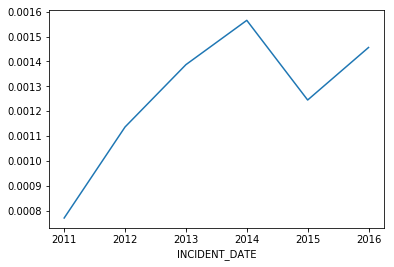

In [27]:
# Let's see what our average number injuries per year data looks like
# Looks like injuries are somewhat on the rise
df.resample('Y')['Injuries'].mean().plot()

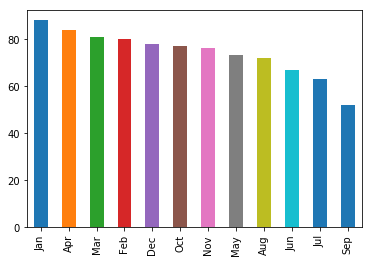

In [28]:
# Chart total number of injuries by month
# Looks like January leads in the number of injuries
df.groupby(df.index.strftime('%b'))['Injuries'].sum().nlargest(12).plot(kind='bar')

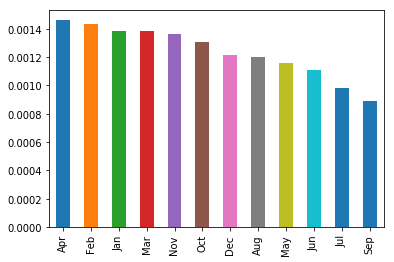

In [29]:
# But perhaps January has more injuries just because there are more calls
# So, let's chart the average number of injuries by month
# Seems the top 3 leading months are generally the same as above
df.groupby(df.index.strftime('%b'))['Injuries'].mean().nlargest(12).plot(kind='bar')

## Data Analysis - Response Types

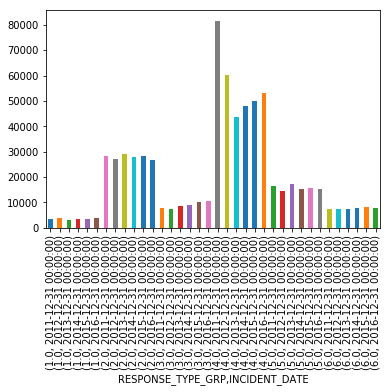

In [30]:
# Visualize the trends of response types by year
# We can see that medical calls (RESPONSE_TYPE_GRP = 4) has the highest frequency (are most common)
# Medical calls decreased from 2001 to 2013 and then started to increase again from 2013 to 2016
# Other RESPONSE_TYPE_GRPs do not appear to have changed a great deal but it's difficult to see here
df.groupby(['RESPONSE_TYPE_GRP', pd.Grouper(freq='Y')])['RESPONSE_TYPE_GRP'].count().plot(kind='bar')

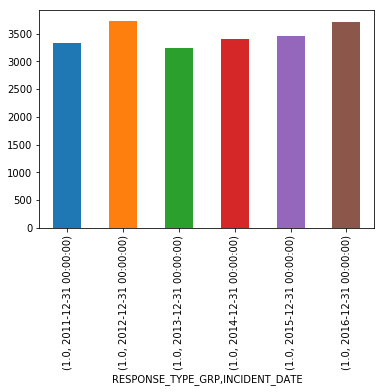

In [31]:
# Let's check out each response type individuallly 
# Not a whole lot of change to the number of fire related calls
df[df.RESPONSE_TYPE_GRP == 1].groupby(['RESPONSE_TYPE_GRP', pd.Grouper(freq='Y')])['RESPONSE_TYPE_GRP'].count().plot(kind='bar')

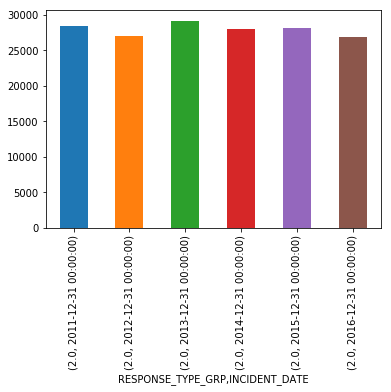

In [32]:
# Not a lot of change in the number of false alarm calls from year to year
df[df.RESPONSE_TYPE_GRP == 2].groupby(['RESPONSE_TYPE_GRP', pd.Grouper(freq='Y')])['RESPONSE_TYPE_GRP'].count().plot(kind='bar')

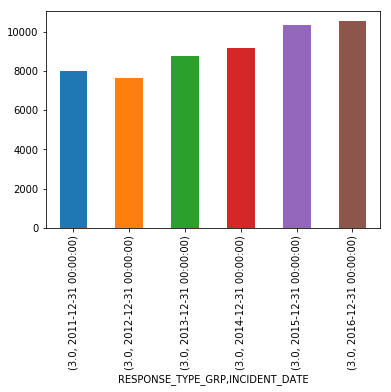

In [33]:
# There seems to be an increase in the amount of rescue calls  
df[df.RESPONSE_TYPE_GRP == 3].groupby(['RESPONSE_TYPE_GRP', pd.Grouper(freq='Y')])['RESPONSE_TYPE_GRP'].count().plot(kind='bar')

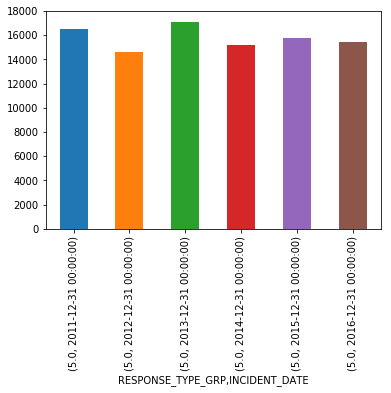

In [34]:
# There was significantly more calls of type 'other' in 2013 than in other years
df[df.RESPONSE_TYPE_GRP == 5].groupby(['RESPONSE_TYPE_GRP', pd.Grouper(freq='Y')])['RESPONSE_TYPE_GRP'].count().plot(kind='bar')

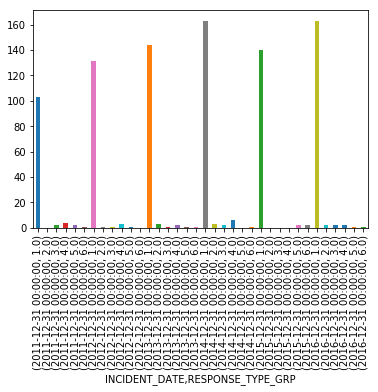

In [35]:
# Visualize the trends of injuries by response types per year
# We can see that Fire/explosion/heat related calls have the greatest number of injuries
# by far, and the number of injuries has been generally increasing since 2011 
df.groupby([pd.Grouper(freq='Y'), 'RESPONSE_TYPE_GRP'])['Injuries'].sum().plot(kind='bar')

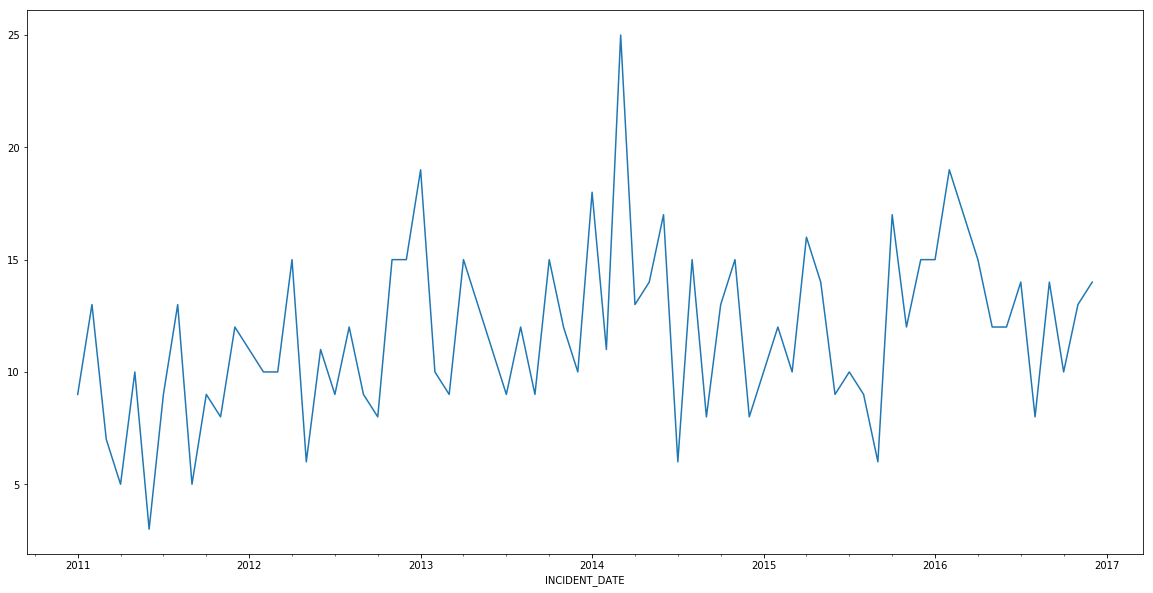

In [36]:
# Chart injury trend for fire/explosion/heat related events over the time period
df[df.RESPONSE_TYPE_GRP == 1].groupby([pd.Grouper(freq='M')])['Injuries'].sum().plot(figsize=(20,10))

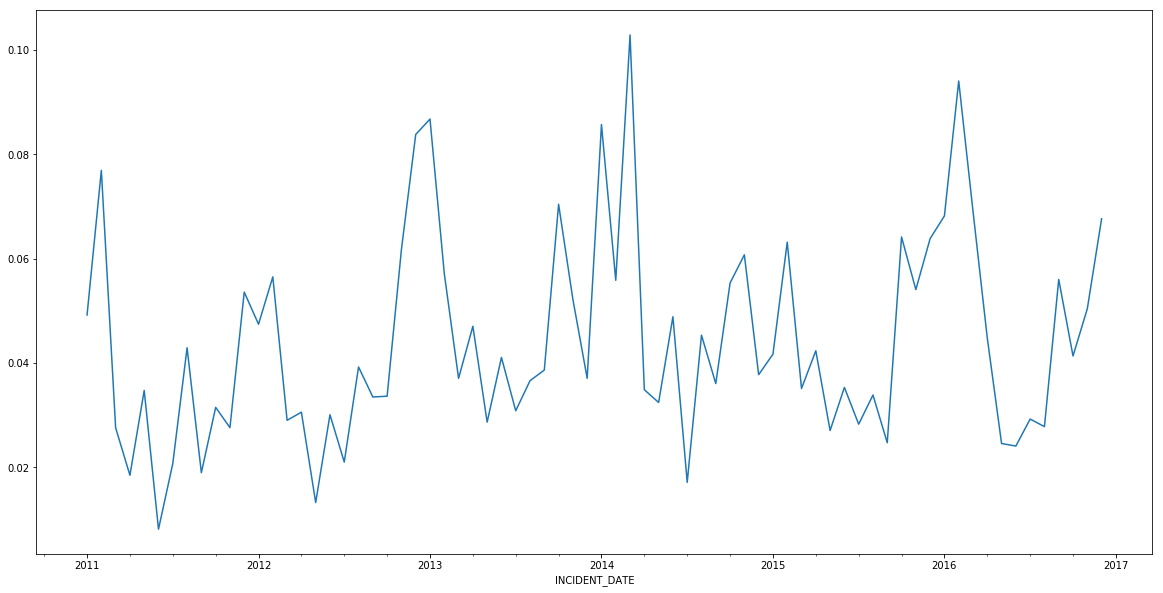

In [37]:
# Let's also look at the mean in case some months had relatively more incidents and therefore, possibly
# also a higher number of injuries
df[df.RESPONSE_TYPE_GRP == 1].groupby([pd.Grouper(freq='M')])['Injuries'].mean().plot(figsize=(20,10))

## Predictive Modelling
### Predicting Injuries

In [39]:
# Let's find the 10 attributes with highest correlation with Injuries
df.corr().abs().xs("Injuries").nlargest(10)

Injuries                1.000000
CIVILIAN_FIRE_INJURY    0.708551
FF_INJURIES             0.436920
PHYSICAL_CONDITION_2    0.353647
AREA_OF_ORIGIN          0.295343
OCC_STATUS              0.294453
BLD_STATUS              0.291113
OCC_TYPE                0.282247
Detection               0.277631
AGE_OF_STRUCTURE        0.274499
Name: Injuries, dtype: float64

In [40]:
# We'll exclude PHYSICAL_CONDITION2 as it is an outcome type of attribute, 
# not an input/a predictor 
df_model = df[['AREA_OF_ORIGIN','OCC_STATUS','BLD_STATUS','OCC_TYPE','Detection','Injuries']].copy()
df_model.head()

,AREA_OF_ORIGIN,OCC_STATUS,BLD_STATUS,OCC_TYPE,Detection,Injuries
INCIDENT_DATE,,,,,,
2011-01-01,99.0,9.0,9.0,9.0,-1,0
2011-01-01,99.0,9.0,9.0,9.0,-1,0
2011-01-01,99.0,9.0,9.0,9.0,-1,0
2011-01-01,99.0,9.0,9.0,9.0,-1,0
2011-01-01,99.0,9.0,9.0,9.0,-1,0


In [41]:
#Loading necessary libraries
import numpy as np # linear algebra
from sklearn.naive_bayes import GaussianNB # Gaussian Naive Bayes
from sklearn import tree #Look at documentation: http://scikit-learn.org/stable/modules/tree.html
from sklearn import model_selection

from sklearn.model_selection import train_test_split # Helping you divide your datasets to train/test(validation)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [42]:
#Initialize Gaussian Naive Bayes
clf = GaussianNB()
# Split-out validation dataset
array = df_model.values
X = array[:,0:5] # Features/Independent Variables
Y = array[:,5] # Response/Class Variable

# One-third of data as a part of test set
validation_size = 0.33

seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

train_size = len(X_train)
val_size = len(X_validation)
print(val_size)
print(train_size)

237723
482647


In [43]:
# Test options and evaluation metric
scoring = 'accuracy'

#Fitting the training set
clf.fit(X_train, Y_train) 

# Predicting for the Test(Validation) Set
pred_clf = clf.predict(X_validation)

GaussianNB(priors=None)

In [44]:
#Model Performance
#setting performance parameters
kfold = model_selection.KFold(n_splits=10, random_state=seed)

#calling the cross validation function
cv_results = model_selection.cross_val_score(GaussianNB(), X_train, Y_train, cv=kfold, scoring=scoring)

#displaying the mean and standard deviation of the prediction
msg = "%s: %f (%f)" % ('NB accuracy', cv_results.mean(), cv_results.std())
print(msg)

NB accuracy: 0.988317 (0.000520)


## Attempt at Geomapping visualization...

In [46]:
# Let's examine address related attributes in the data set...
df[df.FSA.notnull()][['INCIDENT_NUMBER','MAIN_STREET','CROSS_STREET','FSA']].head()
df[df.FSA.isnull() & (df.CROSS_STREET.notnull() & df.MAIN_STREET.notnull())][['INCIDENT_NUMBER','MAIN_STREET','CROSS_STREET','FSA']]

,INCIDENT_NUMBER,MAIN_STREET,CROSS_STREET,FSA
INCIDENT_DATE,,,,
2011-01-01,F11000010,NaN,NaN,M6N
2011-01-01,F11000012,NaN,NaN,M4M
2011-01-01,F11000017,NaN,NaN,M4J
2011-01-01,F11000018,NaN,NaN,M6K
2011-01-01,F11000021,NaN,NaN,M3A


,INCIDENT_NUMBER,MAIN_STREET,CROSS_STREET,FSA
INCIDENT_DATE,,,,
2011-01-01,F11000011,MOUNT PLEASANT RD,LAWRENCE AVE E,NaN
2011-01-01,F11000013,DUFFERIN ST,SYLVAN AVE,NaN
2011-01-01,F11000014,SAN ROMANOWAY,SAN VAROWAY,NaN
2011-01-01,F11000015,THORNCLIFFE PARK DR,WEST DON RIVER TRL,NaN
2011-01-01,F11000016,ERNEST AVE,LN W PERTH N RANDOLPH,NaN
2011-01-01,F11000019,SECORD AVE,BARRINGTON AVE,NaN
2011-01-01,F11000020,DIXON RD,DIXON PARK TRL,NaN
2011-01-01,F11000022,EDGEWOOD AVE,FITZGERALD MEWS,NaN
2011-01-01,F11000024,KIPLING AVE,HORNER AVE,NaN


In [47]:
# Note that the blank data is actually filled with whitespace so the value is not null
mystr = df.loc[df.INCIDENT_NUMBER == 'F11000078', 'MAIN_STREET'].values[0]
mystr

'  '

In [48]:
# Let's remove all leading and trailing whitespace
df.loc[df.MAIN_STREET.notnull(),'MAIN_STREET'] = df[df.MAIN_STREET.notnull()][['MAIN_STREET']].apply(lambda x: x.str.strip())
df.loc[df.MAIN_STREET.notnull(),'CROSS_STREET'] = df[df.MAIN_STREET.notnull()][['CROSS_STREET']].apply(lambda x: x.str.strip())

# And convert those that are blank with NaN
df['MAIN_STREET'].replace('', np.nan, inplace=True)
df['CROSS_STREET'].replace('', np.nan, inplace=True)

In [49]:
# Let's use the FSA (postal code) data where available and intersection info otherwise
df.loc[df.FSA.notnull(), 'Address'] = df[df.FSA.notnull()]['FSA']
df.loc[df.FSA.isnull() & df.MAIN_STREET.notnull() & df.CROSS_STREET.notnull(), 'Address'] = df[df.FSA.isnull()  & df.MAIN_STREET.notnull() & df.CROSS_STREET.notnull()]['MAIN_STREET'] + " " + df[df.FSA.isnull()  & df.MAIN_STREET.notnull() & df.CROSS_STREET.notnull()]['CROSS_STREET']
df[['Address']].head()

,Address
INCIDENT_DATE,
2011-01-01,M6N
2011-01-01,MOUNT PLEASANT RD LAWRENCE AVE E
2011-01-01,M4M
2011-01-01,DUFFERIN ST SYLVAN AVE
2011-01-01,SAN ROMANOWAY SAN VAROWAY


In [ ]:
# The following attempts to get latitude and longitude info for each address via Google
# but their API has quota and requires a paid subscription
# Latitude and Longitude info are required for many geo mapping libraries
import requests
for index, row in df.iterrows():
    address = str(row['Address'])
    response = requests.get('https://maps.googleapis.com/maps/api/geocode/json?address=' + address)
    json_response = response.json()
    if (len(json_response)):
        continue
    df.at[index,'lat'] = json_response['results'][0]['geometry']['location']['lat']
    df.at[index,'long'] = json_response['results'][0]['geometry']['location']['lng']
    
df[['lat','long']].info()

<hr/>
<hr/>
<hr/>

In [ ]:
# Which data do we trust ...
# ... if sum of (RESCUED_ADULTS, RESCUED_CHILDREN, RESCUED_SENIORS) do not match total in RESCUES?
# ... if PHYSICAL_CONDITION_* code (2 to 8) indicates there are rescues but RESCUE* attributes indicate 0 rescues?
# ... if PHYSICAL_CONDITION_* code (1 or 98) indicates there are no rescues but RESCUE* attributes indicate >0 rescues?
# ....if PHYSICAL_CONDITION_1 code indicates there are rescues but PHYSICAL_CONDITION_2 indicates no rescues?